IMPORTING PACKAGES

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

EXTRACTING DATA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

df =pd.read_csv("drive/My Drive/Quant/stock_prices.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.785904,135480400
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,73.068573,146322800
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.650787,118387200
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,73.304413,108872000
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,74.483597,132079200
...,...,...,...,...,...,...,...
248,2020-12-24,131.320007,133.460007,131.100006,131.970001,130.802322,54930100
249,2020-12-28,133.990005,137.339996,133.509995,136.690002,135.480591,124486200
250,2020-12-29,138.050003,138.789993,134.339996,134.869995,133.676682,121047300
251,2020-12-30,135.580002,135.990005,133.399994,133.720001,132.536850,96452100


PLUS_DI

In [4]:
def p_di(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    return plus_di
    

MINUS_DI

In [5]:
def m_di(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    return minus_di

ADX 

In [6]:
def adx(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return  adx_smooth

ADX, +DI, -DI

In [7]:
def ADX(df: pd.DataFrame(), interval: int=14):
    df['-DM'] = df['Low'].shift(1) - df['Low']
    df['+DM'] = df['High'] - df['High'].shift(1)
    df['+DM'] = np.where((df['+DM'] > df['-DM']) & (df['+DM']>0), df['+DM'], 0.0)
    df['-DM'] = np.where((df['-DM'] > df['+DM']) & (df['-DM']>0), df['-DM'], 0.0)

    df['TR_TMP1'] = df['High'] - df['Low']
    df['TR_TMP2'] = np.abs(df['High'] - df['Adj Close'].shift(1))
    df['TR_TMP3'] = np.abs(df['Low'] - df['Adj Close'].shift(1))
    df['TR'] = df[['TR_TMP1', 'TR_TMP2', 'TR_TMP3']].max(axis=1)

    df['TR'+str(interval)] = df['TR'].rolling(interval).mean()
    # df['+DMI'+str(interval)] = df['+DM'].rolling(interval).sum()
    # df['-DMI'+str(interval)] = df['-DM'].rolling(interval).sum()

    df['+DI'+str(interval)] = (df['+DM'].ewm(alpha = 1/interval).mean() /   df['TR'+str(interval)])*100
    df['-DI'+str(interval)] = (df['-DM'].ewm(alpha = 1/interval).mean() / df['TR'+str(interval)])*100


    df['DX'] = ((abs(df['+DI'+str(interval)] - df['-DI'+str(interval)]))/(abs(df['+DI'+str(interval)] + df['-DI'+str(interval)])))*100

    df['ADX'] = (df['DX'].shift(1)*(interval-1) + df['DX']) / interval
    df['ADX'+str(interval)] =  df['ADX'].ewm(alpha = 1/interval).mean()
    del df['+DM'], df['-DM']
    del df['TR_TMP1'], df['TR_TMP2'], df['TR_TMP3'], df['TR'], df['TR'+str(interval)]
    del df['DX'], df['ADX']
    return df

In [8]:
df_adx = ADX(df, 14)
print(df_adx)

           Date        Open        High         Low       Close   Adj Close  \
0    2020-01-02   74.059998   75.150002   73.797501   75.087502   73.785904   
1    2020-01-03   74.287498   75.144997   74.125000   74.357498   73.068573   
2    2020-01-06   73.447502   74.989998   73.187500   74.949997   73.650787   
3    2020-01-07   74.959999   75.224998   74.370003   74.597504   73.304413   
4    2020-01-08   74.290001   76.110001   74.290001   75.797501   74.483597   
..          ...         ...         ...         ...         ...         ...   
248  2020-12-24  131.320007  133.460007  131.100006  131.970001  130.802322   
249  2020-12-28  133.990005  137.339996  133.509995  136.690002  135.480591   
250  2020-12-29  138.050003  138.789993  134.339996  134.869995  133.676682   
251  2020-12-30  135.580002  135.990005  133.399994  133.720001  132.536850   
252  2020-12-31  134.080002  134.740005  131.720001  132.690002  131.515976   

        Volume      +DI14      -DI14      ADX14  
0

PLOT DATA

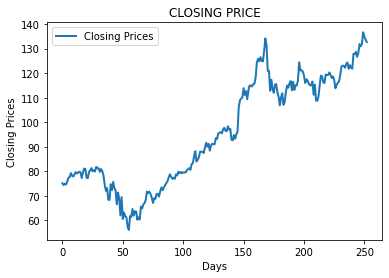

In [9]:
closing_prices = df['Close']
plt.title( 'CLOSING PRICE')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Closing Prices', linewidth = 2)
plt.legend()
plt.show()

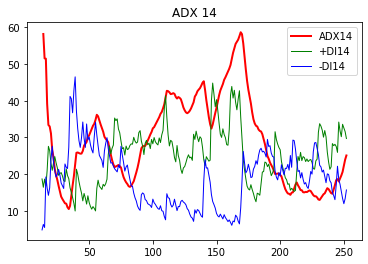

In [10]:
Plus_DI = df_adx['+DI14']
Minus_DI = df_adx['-DI14']
ADX14 = df_adx['ADX14']
plt.title( 'ADX 14')
plt.plot(ADX14, label='ADX14', c='r', linewidth = 2)
plt.plot(Plus_DI, label='+DI14', c='g', linewidth = 1)
plt.plot(Minus_DI, label='-DI14', c='b', linewidth = 1)
plt.legend()
plt.show()

***FISHER TRANSFORM***

FT

In [11]:
    interval = 9 
    max = df['Close'].max()
    min = df['Close'].min() 

    df['Xn'] = (df['Close'] - min) / (max - min)
    df['X_t'] = 2 * df['Xn'] - 1

    for i in range(df['X_t'].shape[0]):
       if df.loc[i,'X_t'] is 1.000000:
          df.loc[i,'X_t'] = 0.999999
       if df.loc[i,'X_t'] is -1.000000:
          df.loc[i,'X_t'] = -0.999999

    df['X'] = df['X_t'].rolling(interval).mean()

    
    df['FT_temp'] = (np.log((1 + df['X']) / (1 - df['X'])))
    df['FT_temp1'] = (df['FT_temp'] * 0.5).rolling(interval).mean()
    df['FT'] = df['FT_temp1']
    df['MA_ft'] = df['FT'].rolling(interval).mean()
    del df['Xn'], df['X_t']
    del df['FT_temp'], df['FT_temp1']

<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-11-8b8c803f025c>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if df.loc[i,'X_t'] is 1.000000:
<ipython-input-11-8b8c803f025c>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if df.loc[i,'X_t'] is -1.000000:


In [12]:
print(df.drop('MA_ft' , axis=1))

           Date        Open        High         Low       Close   Adj Close  \
0    2020-01-02   74.059998   75.150002   73.797501   75.087502   73.785904   
1    2020-01-03   74.287498   75.144997   74.125000   74.357498   73.068573   
2    2020-01-06   73.447502   74.989998   73.187500   74.949997   73.650787   
3    2020-01-07   74.959999   75.224998   74.370003   74.597504   73.304413   
4    2020-01-08   74.290001   76.110001   74.290001   75.797501   74.483597   
..          ...         ...         ...         ...         ...         ...   
248  2020-12-24  131.320007  133.460007  131.100006  131.970001  130.802322   
249  2020-12-28  133.990005  137.339996  133.509995  136.690002  135.480591   
250  2020-12-29  138.050003  138.789993  134.339996  134.869995  133.676682   
251  2020-12-30  135.580002  135.990005  133.399994  133.720001  132.536850   
252  2020-12-31  134.080002  134.740005  131.720001  132.690002  131.515976   

        Volume      +DI14      -DI14      ADX14    

PLOTTING DATA

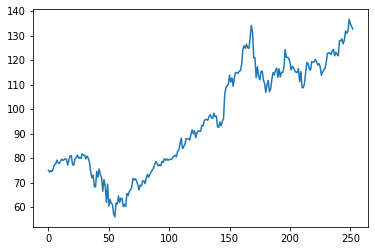

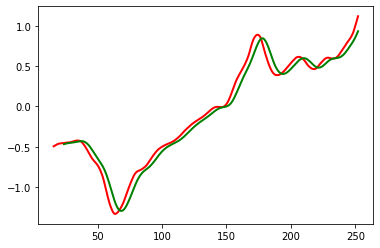

In [13]:
plt.figure(1)
plt.plot(df['Close'])
plt.figure(2)
plt.plot(df['FT'], label='FT 9', linewidth = 2, c='r')
plt.plot(df['MA_ft'], label='MA_FT 9', linewidth = 2, c='g')
plt.show()

FT1

In [14]:
def FT(df: pd.DataFrame(), period: int=9, adjust: bool = True):
        from numpy import log, seterr

        seterr(divide="ignore")

        med = (df['High'] + df['Low']) / 2
        ndaylow = med.rolling(window=period).min()
        ndayhigh = med.rolling(window=period).max()
        raw = (2 * ((med - ndaylow) / (ndayhigh - ndaylow))) - 1
        smooth = raw.ewm(span=5, adjust=adjust).mean()
        _smooth = smooth.fillna(0)

        return pd.Series((log((1 + _smooth) / (1 - _smooth))).ewm(span=3, adjust=adjust).mean())    

In [15]:
df_ft = FT(df, 14)
print(df_ft)

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
248    2.354132
249    2.711512
250    3.100620
251    2.912556
252    2.473726
Length: 253, dtype: float64


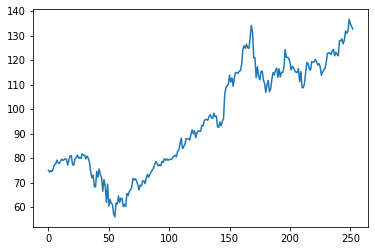

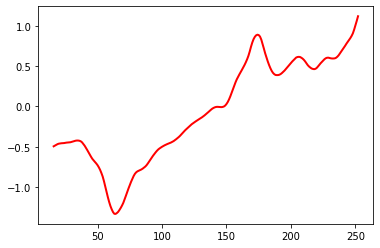

In [16]:
plt.figure(1)
plt.plot(df['Close'])
plt.figure(2)
plt.plot(df['FT'], label='FT 9', linewidth = 2, c='r')
plt.show()